In [1]:
import os
import json

In [2]:
def get_final_particles_from_record(record):
    final_step = record['history'][-1]
    particles = final_step['particles']
    if 'resample_indices' in final_step:
        particles = [
            {**particles[i], **{'weight': final_step['average_weight']}}
            for i in final_step['resample_indices']
        ]
    return particles


def load_results(results_file):
    results = []
    with open(results_file, 'r') as f:
        for line in f:
            results.append(json.loads(line))
    return results


import numpy as np


def mean_log_weight(record):
    particles = get_final_particles_from_record(record)
    return np.mean([p['weight'] for p in particles])


def log_mean_weight(record):
    particles = get_final_particles_from_record(record)
    log_weights = [p['weight'] for p in particles]
    return np.log(np.mean(np.exp(log_weights)))

In [3]:
results_dir = 'replicate_results'

sis_results = load_results(
    os.path.join(results_dir, 'Llama-3.1-8b-sis-0.5-p10-character.jsonl')
)
smc_results = load_results(
    os.path.join(results_dir, 'Llama-3.1-8b-smc-0.5-p10-character.jsonl')
)

In [4]:
n_replicates = 5

question2smc = {}
for i, r in enumerate(smc_results):
    if r['question'] not in question2smc:
        question2smc[r['question']] = [(r, i)]
    else:
        question2smc[r['question']].append((r, i))

question2sis = {}
for i, r in enumerate(sis_results):
    if r['question'] not in question2sis:
        question2sis[r['question']] = [(r, i)]
    else:
        question2sis[r['question']].append((r, i))

# downsample
questions = set(list(question2smc.keys()) + list(question2sis.keys()))
questions_inter = set(question2smc.keys()) & set(question2sis.keys())
for q in questions:
    if q not in questions_inter:
        if q in question2smc:
            del question2smc[q]
        elif q in question2sis:
            del question2sis[q]
    elif (len(question2smc[q]) != n_replicates) or (len(question2sis[q]) != n_replicates):
        del question2smc[q]
        del question2sis[q]

assert len(question2smc) == len(question2sis)
assert all(len(question2smc[q]) == n_replicates for q in question2smc)
assert all(len(question2sis[q]) == n_replicates for q in question2sis)

In [6]:
import pandas as pd

weights = pd.DataFrame(
    columns=[
        'question',
        'index',
        'replicate',
        'method',
        'mean_log_weight',
        'log_mean_weight',
    ]
)
for q in set(question2smc.keys()) & set(question2sis.keys()):
    for j, (r, i) in enumerate(question2smc[q]):
        weights = pd.concat(
            [
                weights,
                pd.DataFrame(
                    {
                        'question': [q],
                        'index': [i],
                        'replicate': [j],
                        'method': ['smc'],
                        'mean_log_weight': [mean_log_weight(r['record'])],
                        'log_mean_weight': [log_mean_weight(r['record'])],
                    }
                ),
            ],
            ignore_index=True,
        )

    for j, (r, i) in enumerate(question2sis[q]):
        weights = pd.concat(
            [
                weights,
                pd.DataFrame(
                    {
                        'question': [q],
                        'index': [i],
                        'replicate': [j],
                        'method': ['sis'],
                        'mean_log_weight': [mean_log_weight(r['record'])],
                        'log_mean_weight': [log_mean_weight(r['record'])],
                    }
                ),
            ],
            ignore_index=True,
        )

/var/tmp/ipykernel_176134/2407753677.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weights = pd.concat([weights, pd.DataFrame({


In [7]:
from scipy.stats import ttest_rel

df = weights

results = []
for question in set(question2smc.keys()) & set(question2sis.keys()):
    smc = df[(df['question'] == question) & (df['method'] == 'smc')]['log_mean_weight']
    sis = df[(df['question'] == question) & (df['method'] == 'sis')]['log_mean_weight']

    if len(smc) == 5 and len(sis) == 5:
        t_stat, p_value = ttest_rel(smc, sis)
        results.append(
            {
                'question': question,
                'difference': np.mean(sis) - np.mean(smc),
                't_stat': t_stat,
                'p_value': p_value,
                'is_significant': p_value < 0.05,
            }
        )
    else:
        raise ValueError(f'Not enough data for question {question}')

difference_df = pd.DataFrame(results)

In [10]:
from plotnine import (
    ggplot,
    aes,
    geom_point,
    geom_bar,
    scale_color_manual,
    labs,
    theme,
    scale_alpha_manual,
    theme_light,
    element_text,
    element_blank,
    guides,
    geom_hline,
    annotate,
)

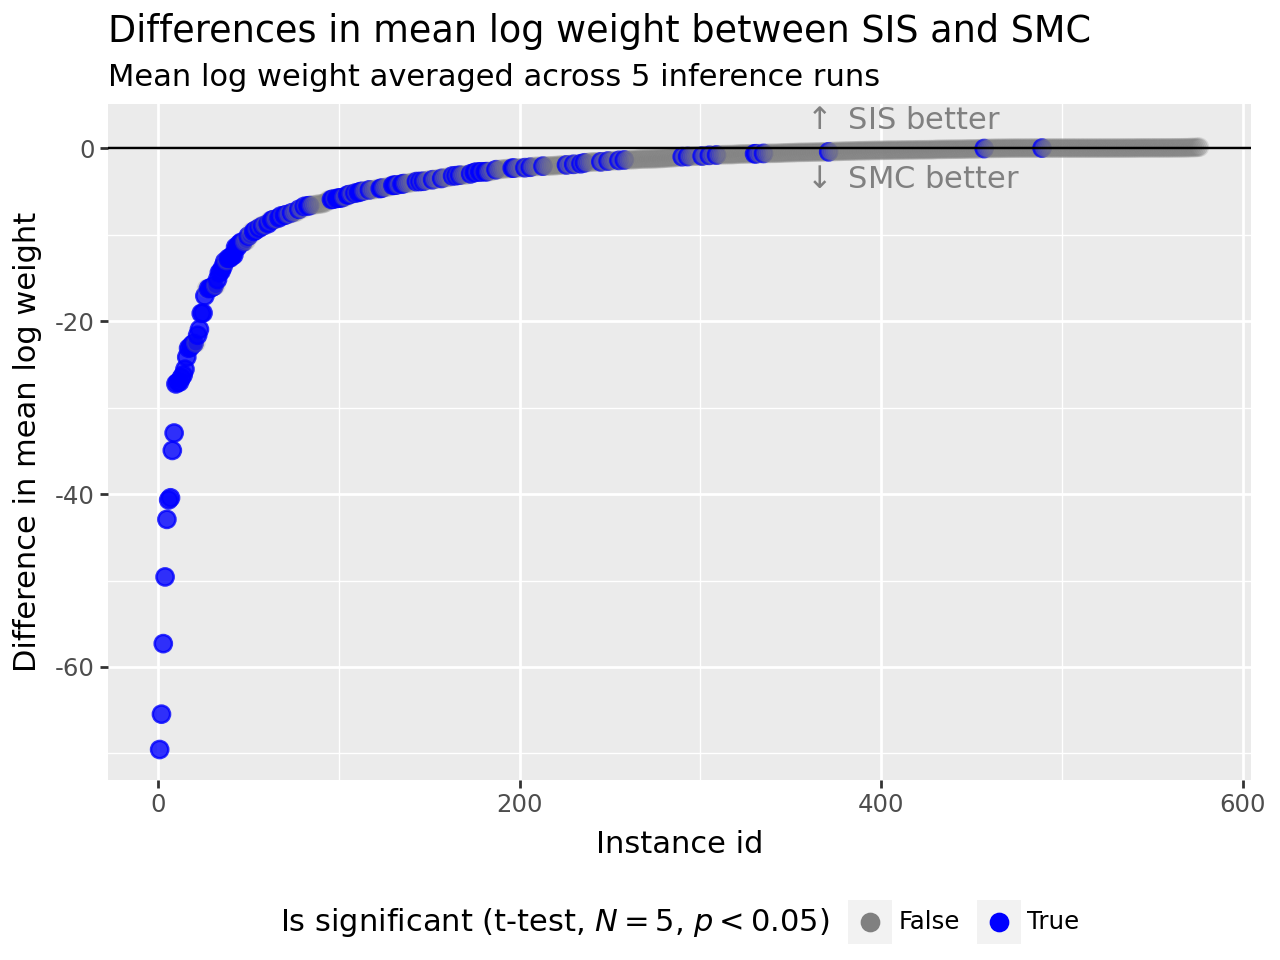

In [ ]:
df = difference_df.sort_values(by='difference').reset_index(drop=True)
question_mapping = {
    question: idx for idx, question in enumerate(df['question'].unique(), start=1)
}
df['question_idx'] = df['question'].map(question_mapping)

scatter_plot = (
    ggplot(
        df,
        aes(
            x='question_idx',
            y='difference',
            color='is_significant',
            alpha='is_significant',
        ),
    )
    + geom_point(size=3)
    + scale_alpha_manual(values={True: 0.8, False: 0.2})
    + scale_color_manual(values={True: 'blue', False: 'grey'})
    + geom_hline(yintercept=0, linetype='solid', color='black')
    + annotate(
        'text',
        x=350,
        y=1.5,
        label=' $\\uparrow$ SIS better',
        ha='left',
        va='bottom',
        color='grey',
    )
    + annotate(
        'text',
        x=350,
        y=-2,
        label=' $\\downarrow$ SMC better',
        ha='left',
        va='top',
        color='grey',
    )
    + labs(
        title='Differences in mean log weight between SIS and SMC',
        subtitle='Mean log weight averaged across 5 inference runs',
        x='Instance id',
        y='Difference in mean log weight',
        color='Is significant (t-test, $N = 5$, $p < 0.05$)',
    )
    + guides(alpha='none')
    + theme(legend_position='bottom')
)

scatter_plot

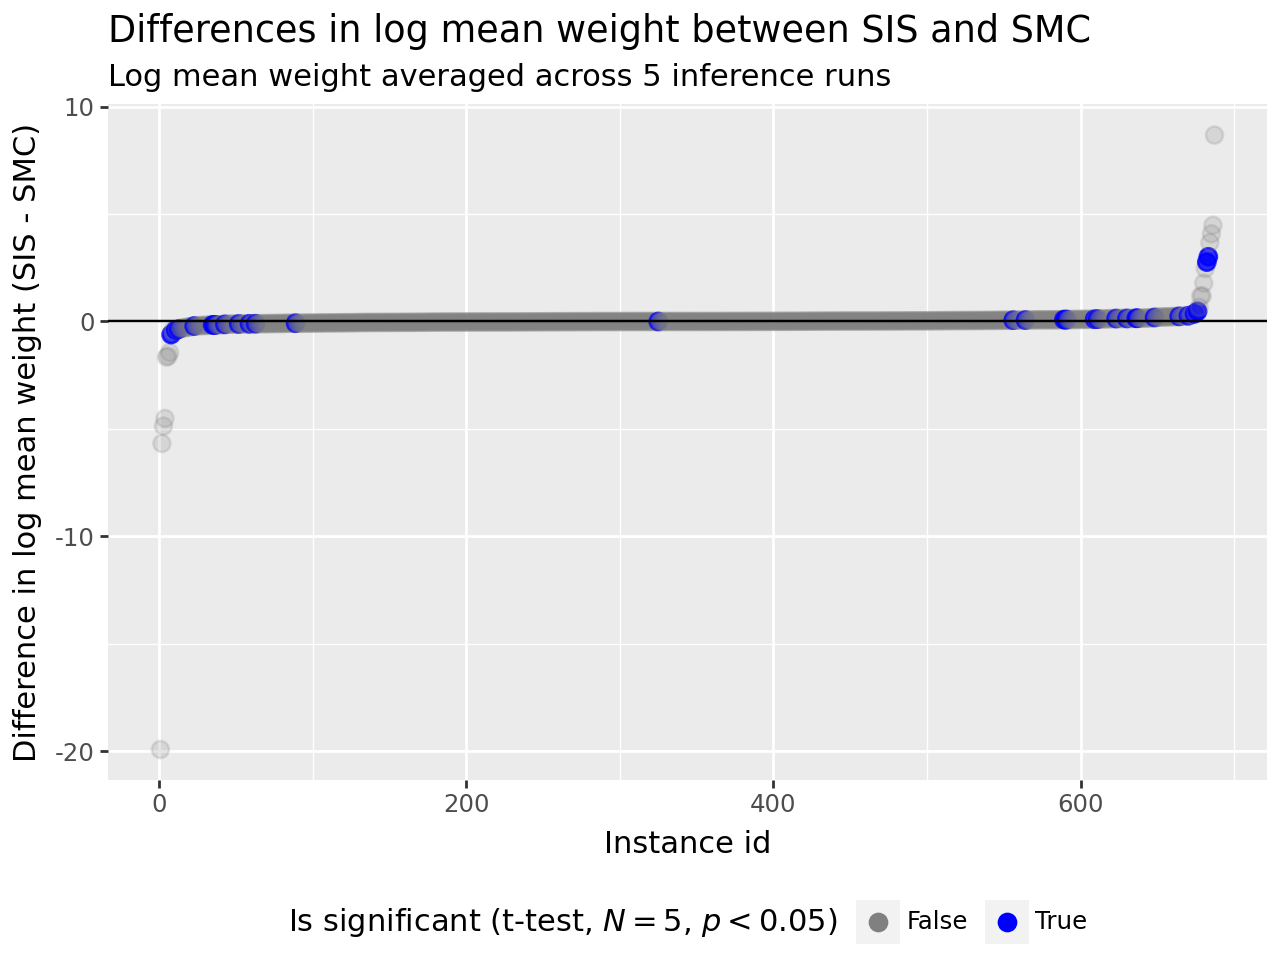

In [13]:
df = difference_df.sort_values(by='difference').reset_index(drop=True)
question_mapping = {
    question: idx for idx, question in enumerate(df['question'].unique(), start=1)
}
df['question_idx'] = df['question'].map(question_mapping)

scatter_plot = (
    ggplot(
        df,
        aes(
            x='question_idx',
            y='difference',
            color='is_significant',
            alpha='is_significant',
        ),
    )
    + geom_point(size=3)
    + scale_alpha_manual(values={True: 0.8, False: 0.2})
    + scale_color_manual(values={True: 'blue', False: 'grey'})
    + geom_hline(yintercept=0, linetype='solid', color='black')
    +
    # annotate('text', x=350, y=0.5, label=' $\\uparrow$ SIS better', ha='left', va='bottom', color='grey') +
    # annotate('text', x=350, y=-0.5, label=' $\\downarrow$ SMC better', ha='left', va='top', color='grey') +
    labs(
        title='Differences in log mean weight between SIS and SMC',
        subtitle='Log mean weight averaged across 5 inference runs',
        x='Instance id',
        y='Difference in log mean weight (SIS - SMC)',
        color='Is significant (t-test, $N = 5$, $p < 0.05$)',
    )
    + guides(alpha='none')
    + theme(legend_position='bottom')
)

scatter_plot

----

# CalFlow

In [4]:
import os

results_sis = [
    f'first-turn-utterance-t50d50-p10-lpoe-True-shot-20-seed-{i}.jsonl'
    for i in range(1, 21)
]
results_smc = [
    f'first-turn-utterance-t50d50-p10-lpoe-False-shot-20-seed-{i}.jsonl'
    for i in range(1, 21)
]

In [5]:
sis_results = []
for f in results_sis:
    sis_results.extend(load_results(os.path.join('/home/leodu/genparse/runs/calflow', f)))

smc_results = []
for f in results_smc:
    smc_results.extend(load_results(os.path.join('/home/leodu/genparse/runs/calflow', f)))

In [6]:
n_replicates = 20
unique_id = 'dialogue_id'

question2smc = {}
for i, r in enumerate(smc_results):
    if r[unique_id] not in question2smc:
        question2smc[r[unique_id]] = [(r, i)]
    else:
        question2smc[r[unique_id]].append((r, i))

question2sis = {}
for i, r in enumerate(sis_results):
    if r[unique_id] not in question2sis:
        question2sis[r[unique_id]] = [(r, i)]
    else:
        question2sis[r[unique_id]].append((r, i))

# downsample
questions = set(list(question2smc.keys()) + list(question2sis.keys()))
questions_inter = set(question2smc.keys()) & set(question2sis.keys())
for q in questions:
    if q not in questions_inter:
        if q in question2smc:
            del question2smc[q]
        elif q in question2sis:
            del question2sis[q]
    elif (len(question2smc[q]) != n_replicates) or (len(question2sis[q]) != n_replicates):
        del question2smc[q]
        del question2sis[q]

assert len(question2smc) == len(question2sis)
assert all(len(question2smc[q]) == n_replicates for q in question2smc)
assert all(len(question2sis[q]) == n_replicates for q in question2sis)

In [7]:
import pandas as pd

results = pd.DataFrame(
    columns=[
        'question',
        'index',
        'replicate',
        'method',
        'mean_log_weight',
        'log_mean_weight',
    ]
)
for q in set(question2smc.keys()) & set(question2sis.keys()):
    for j, (r, i) in enumerate(question2smc[q]):
        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    {
                        'question': [q],
                        'index': [i],
                        'replicate': [j],
                        'method': ['smc'],
                        'mean_log_weight': [mean_log_weight(r['record'])],
                        'log_mean_weight': [log_mean_weight(r['record'])],
                    }
                ),
            ],
            ignore_index=True,
        )

    for j, (r, i) in enumerate(question2sis[q]):
        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    {
                        'question': [q],
                        'index': [i],
                        'replicate': [j],
                        'method': ['sis'],
                        'mean_log_weight': [mean_log_weight(r['record'])],
                        'log_mean_weight': [log_mean_weight(r['record'])],
                    }
                ),
            ],
            ignore_index=True,
        )

/var/tmp/ipykernel_4125/1434239417.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


In [8]:
results.head(5)

,question,index,replicate,method,mean_log_weight,log_mean_weight
0,fb5d975d-7d3d-48c0-8bea-75b02644bf60,29,0,smc,-41.104004,-5.177613
1,fb5d975d-7d3d-48c0-8bea-75b02644bf60,79,1,smc,-52.181375,-5.249455
2,fb5d975d-7d3d-48c0-8bea-75b02644bf60,129,2,smc,-132.759441,-5.458381
3,fb5d975d-7d3d-48c0-8bea-75b02644bf60,179,3,smc,-49.751512,-4.659047
4,fb5d975d-7d3d-48c0-8bea-75b02644bf60,229,4,smc,-71.995184,-6.264778


In [9]:
from scipy.stats import ttest_rel

df = results

pivot_results = []
for unique_id in set(question2smc.keys()) & set(question2sis.keys()):
    for metric in ['mean_log_weight', 'log_mean_weight']:
        smc = df[(df['question'] == unique_id) & (df['method'] == 'smc')][metric]
        sis = df[(df['question'] == unique_id) & (df['method'] == 'sis')][metric]

        if len(smc) == n_replicates and len(sis) == n_replicates:
            t_stat, p_value = ttest_rel(smc, sis)
            pivot_results.append(
                {
                    'unique_id': unique_id,
                    'difference': np.mean(sis) - np.mean(smc),
                    't_stat': t_stat,
                    'p_value': p_value,
                    'is_significant': p_value < 0.05,
                    'metric': metric,
                }
            )
        else:
            raise ValueError(
                f'Not enough data for unique_id {unique_id}, {len(smc)}, {len(sis)}'
            )

difference_df = pd.DataFrame(pivot_results)

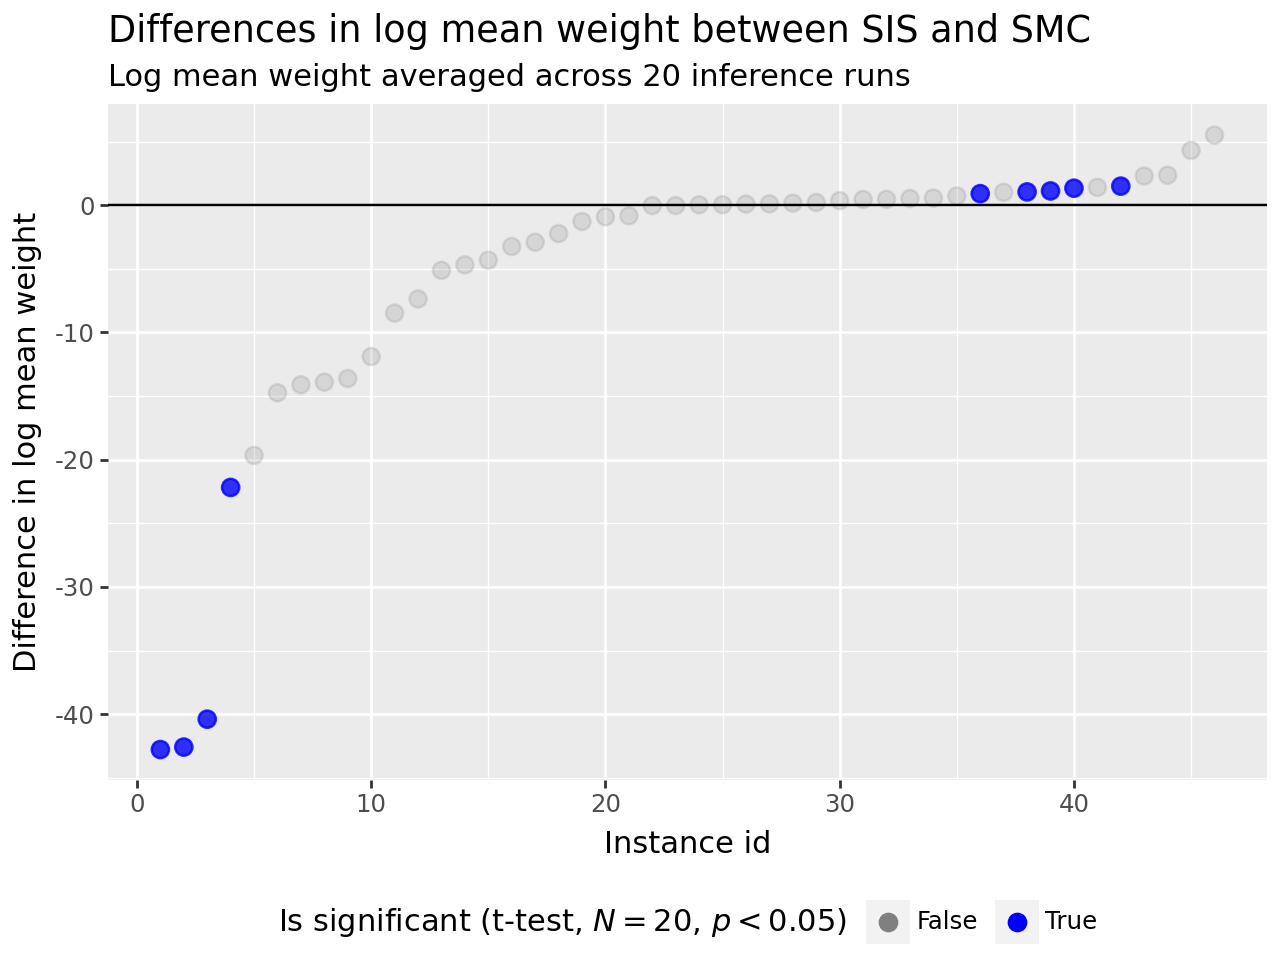

In [11]:
from plotnine import (
    ggplot,
    aes,
    geom_point,
    scale_color_manual,
    labs,
    theme,
    scale_alpha_manual,
    guides,
    geom_hline,
    annotate,
)

df = (
    difference_df[difference_df['metric'] == 'log_mean_weight']
    .sort_values(by='difference')
    .reset_index(drop=True)
)
question_mapping = {
    question: idx for idx, question in enumerate(df['unique_id'].unique(), start=1)
}
df['question_idx'] = df['unique_id'].map(question_mapping)

scatter_plot = (
    ggplot(
        df,
        aes(
            x='question_idx',
            y='difference',
            color='is_significant',
            alpha='is_significant',
        ),
    )
    + geom_point(size=3)
    + scale_alpha_manual(values={True: 0.8, False: 0.2})
    + scale_color_manual(values={True: 'blue', False: 'grey'})
    + geom_hline(yintercept=0, linetype='solid', color='black')
    +
    # annotate('text', x=350, y=1.5, label=' $\\uparrow$ SIS better', ha='left', va='bottom', color='grey') +
    # annotate('text', x=350, y=-2, label=' $\\downarrow$ SMC better', ha='left', va='top', color='grey') +
    labs(
        title='Differences in log mean weight between SIS and SMC',
        subtitle=f'Log mean weight averaged across {n_replicates} inference runs',
        x='Instance id',
        y='Difference in log mean weight',
        color=f'Is significant (t-test, $N = ${n_replicates}, $p < 0.05$)',
    )
    + guides(alpha='none')
    + theme(legend_position='bottom')
)

scatter_plot